## Imports

In [ ]:
import os
import sys
import shutil 
from distutils.dir_util import copy_tree # Shutil doesn't preserve meta
import random
import time
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import HTML
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
plt.style.use("ggplot")

In [ ]:
pd.set_option('display.max_columns', None)  
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', None)

## Load Dataset

In [ ]:
if not os.path.isfile("LES_1m.zip"):
  !mkdir -p data
  !wget -O 'LES_1m.zip' https://raw.githubusercontent.com/nirvana0311/ml_datasets/master/labeledEligibilitySample1000000.zip

In [ ]:
large_data = pd.read_csv('LES_1m.zip', usecols=[1,2], names=['label','prescription'])

In [ ]:
large_data.head()

,label,prescription
0,0,study interventions are recombinant CD40-ligand . melanoma skin diagnosis and no active cns metastases by ct scan or mri
1,0,study interventions are Liposomal doxorubicin . colorectal cancer diagnosis and cardiovascular
2,0,study interventions are BI 836909 . multiple myeloma diagnosis and indwelling central venous cateder or willingness to undergo intra venous central line placement
3,0,study interventions are Immunoglobulins . recurrent fallopian tube carcinoma diagnosis and patients are allowed to receive but are not required to receive two additional cytotoxic regimens for management of recurrent or persistent disease with no more than one non platinum non taxane regimen
4,0,study interventions are Paclitaxel . stage ovarian cancer diagnosis and patients must have recovered from the effects of recent surgery radiotherapy or other therapy


In [ ]:
small_data = large_data.iloc[:100, :] 
small_data.to_csv('data/small_data.csv', index=False) # Select only first 100 rows

## Data Filtering & Preprocessing

In [ ]:
large_data['prescription'].apply(lambda x: len(x.split())).describe()
# Min token count is 4
# Max token count is 439

count    1000000.000000
mean          21.219562
std           11.540169
min            4.000000
25%           14.000000
50%           19.000000
75%           25.000000
max          439.000000
Name: prescription, dtype: float64

In [ ]:
# Max length sequence threshold
# About 4 sequences cross the max_raw_seq_length threshold
max_raw_seq_length = 205

In [ ]:
# Truncating longer prescription sequences to 205 words, Max Sequence length observd in dataset contains 439 tokens
# Bert operates on 512 tokens (But for sequences with unseen vocab it might double the tokens, which can result in index errors[Limitation of BERT, Fixed length])
large_data['prescription'] = large_data['prescription'].str.split().str.slice(start=0, stop=max_raw_seq_length).str.join(" ").str.strip()

In [ ]:
lg_data = large_data.copy()
large_data = None

In [ ]:
lg_data[['intervention','condition']] = lg_data['prescription'].str.split('.', n=1, expand=True)
lg_data['intervention'] = lg_data['intervention'].str.strip()
lg_data['condition'] = lg_data['condition'].str.strip()

In [ ]:
lg_data['intervention'] = lg_data['intervention'].str.extract('(?<=are )(.*)', expand=False)

In [ ]:
lg_data.head()

,label,prescription,intervention,condition
0,0,study interventions are recombinant CD40-ligand . melanoma skin diagnosis and no active cns metastases by ct scan or mri,recombinant CD40-ligand,melanoma skin diagnosis and no active cns metastases by ct scan or mri
1,0,study interventions are Liposomal doxorubicin . colorectal cancer diagnosis and cardiovascular,Liposomal doxorubicin,colorectal cancer diagnosis and cardiovascular
2,0,study interventions are BI 836909 . multiple myeloma diagnosis and indwelling central venous cateder or willingness to undergo intra venous central line placement,BI 836909,multiple myeloma diagnosis and indwelling central venous cateder or willingness to undergo intra venous central line placement
3,0,study interventions are Immunoglobulins . recurrent fallopian tube carcinoma diagnosis and patients are allowed to receive but are not required to receive two additional cytotoxic regimens for management of recurrent or persistent disease with no more than one non platinum non taxane regimen,Immunoglobulins,recurrent fallopian tube carcinoma diagnosis and patients are allowed to receive but are not required to receive two additional cytotoxic regimens for management of recurrent or persistent disease with no more than one non platinum non taxane regimen
4,0,study interventions are Paclitaxel . stage ovarian cancer diagnosis and patients must have recovered from the effects of recent surgery radiotherapy or other therapy,Paclitaxel,stage ovarian cancer diagnosis and patients must have recovered from the effects of recent surgery radiotherapy or other therapy


### Discarding [Missing, Incomplete, Bad] entries



In [ ]:
# Overview
bad_lg_data = lg_data[(lg_data.isnull().any(axis=1)) | (lg_data['condition'] == '')]
bad_lg_data

,label,prescription,intervention,condition
5,0,study interventions are Antibodies,Antibodies,None
26,0,study interventions are Antibodies,Antibodies,None
45,0,study interventions are Antibodies,Antibodies,None
52,0,study interventions are Antibodies,Antibodies,None
73,0,study interventions are Antibodies,Antibodies,None
...,...,...,...,...
999923,1,study interventions are Antibodies,Antibodies,None
999934,1,study interventions are Antibodies,Antibodies,None
999939,1,study interventions are Antineoplastic Agents,Antineoplastic Agents,None
999950,1,study interventions are Antibodies,Antibodies,None


In [ ]:
print(bad_lg_data.shape)
bad_lg_data.head(5)

(41347, 4)


,label,prescription,intervention,condition
5,0,study interventions are Antibodies,Antibodies,None
26,0,study interventions are Antibodies,Antibodies,None
45,0,study interventions are Antibodies,Antibodies,None
52,0,study interventions are Antibodies,Antibodies,None
73,0,study interventions are Antibodies,Antibodies,None


In [ ]:
bad_counts_df = pd.DataFrame(bad_lg_data['intervention'].value_counts()).reset_index().reset_index()
bad_counts_df.columns = ['id', 'intervention', 'count']

In [ ]:
bad_counts_df.head(4)

,id,intervention,count
0,0,Antibodies,34810
1,1,Calcium,2330
2,2,Heparin,253
3,3,Estrogens,230


In [ ]:
# plt.figure(figsize=(20, 6))
# ax = sns.barplot(x="id", y="count", data=bad_counts_df)
# ax.set_yscale("log")
# for ind, label in enumerate(ax.get_xticklabels()):
#     if ind % 10 == 0:  # every 10th label is kept
#         label.set_visible(True)
#     else:
#         label.set_visible(False)
# plt.savefig('bad_dataFreq.png')

In [ ]:
%%html
<iframe src="https://drive.google.com/file/d/1FMwZtNxHJCTwPKuXKJ4ZsdSKUXpgIZCJ/preview" width="1000" height="300"></iframe>

In [ ]:
bad_lg_data = None

In [ ]:
# Discarding above bad entries
lg_data = lg_data[(~lg_data.isnull().any(axis=1)) & (lg_data['condition'] != '')].reset_index(drop=True)

In [ ]:
lg_data.shape

(958653, 4)

In [ ]:
# Removing conditions with only 3 or more characters. Observed conditions 2 meaning conditions.(ny and md)
lg_data = lg_data[~lg_data['condition'].apply(lambda x: True if (len(x) < 3) else False)].reset_index(drop=True)

### Understanding intervention distribution

In [ ]:
lg_data['intervention'].nunique()

14772

In [ ]:
lg_data['condition'].nunique()

596719

In [ ]:
lg_dist = pd.DataFrame(lg_data['intervention'].value_counts())
lg_dist.reset_index(inplace=True)
lg_dist.reset_index(inplace=True)
lg_dist.columns = ['id', 'intervention', 'count']

In [ ]:
lg_dist.head()

,id,intervention,count
0,0,Antibodies,22897
1,1,Paclitaxel,22723
2,2,Albumin-Bound Paclitaxel,21169
3,3,Bevacizumab,20445
4,4,Cyclophosphamide,19981


In [ ]:
# plt.figure(figsize=(20, 6))
# ax = sns.barplot(x="id", y="count", data=lg_dist)
# ax.set_yscale("log")
# for ind, label in enumerate(ax.get_xticklabels()):
#     if ind % 2000 == 0:  # every 2000th label is kept
#         label.set_visible(True)
#     else:
#         label.set_visible(False)
# plt.savefig('lg_dist.png')

In [ ]:
%%html
<iframe src="https://drive.google.com/file/d/1-X1jJu2_95-SjwqKcNY1ofsepiOJfnBA/preview" width="1000" height="300"></iframe>

### Keeping only unique conditions

In [ ]:
uq_lg_data = lg_data.copy()
lg_data = None

In [ ]:
uq_lg_data = uq_lg_data.drop_duplicates(subset=['condition'], ignore_index=True)

In [ ]:
print(uq_lg_data.shape)
uq_lg_data.head(5)

(596719, 4)


,label,prescription,intervention,condition
0,0,study interventions are recombinant CD40-ligand . melanoma skin diagnosis and no active cns metastases by ct scan or mri,recombinant CD40-ligand,melanoma skin diagnosis and no active cns metastases by ct scan or mri
1,0,study interventions are Liposomal doxorubicin . colorectal cancer diagnosis and cardiovascular,Liposomal doxorubicin,colorectal cancer diagnosis and cardiovascular
2,0,study interventions are BI 836909 . multiple myeloma diagnosis and indwelling central venous cateder or willingness to undergo intra venous central line placement,BI 836909,multiple myeloma diagnosis and indwelling central venous cateder or willingness to undergo intra venous central line placement
3,0,study interventions are Immunoglobulins . recurrent fallopian tube carcinoma diagnosis and patients are allowed to receive but are not required to receive two additional cytotoxic regimens for management of recurrent or persistent disease with no more than one non platinum non taxane regimen,Immunoglobulins,recurrent fallopian tube carcinoma diagnosis and patients are allowed to receive but are not required to receive two additional cytotoxic regimens for management of recurrent or persistent disease with no more than one non platinum non taxane regimen
4,0,study interventions are Paclitaxel . stage ovarian cancer diagnosis and patients must have recovered from the effects of recent surgery radiotherapy or other therapy,Paclitaxel,stage ovarian cancer diagnosis and patients must have recovered from the effects of recent surgery radiotherapy or other therapy


In [ ]:
uq_lg_dist = pd.DataFrame(uq_lg_data['intervention'].value_counts())
uq_lg_dist.reset_index(inplace=True)
uq_lg_dist.reset_index(inplace=True)
uq_lg_dist.columns = ['id', 'intervention', 'count']

In [ ]:
uq_lg_dist.head()

,id,intervention,count
0,0,Antibodies,13839
1,1,Paclitaxel,13731
2,2,Albumin-Bound Paclitaxel,12867
3,3,Bevacizumab,12859
4,4,Immunoglobulins,11766


In [ ]:
# plt.figure(figsize=(20, 6))
# ax = sns.barplot(x="id", y="count", data=uq_lg_dist)
# ax.set_yscale("log")
# for ind, label in enumerate(ax.get_xticklabels()):
#     if ind % 1000 == 0:  # every 2000th label is kept
#         label.set_visible(True)
#     else:
#         label.set_visible(False)

# plt.savefig('unique_lg_dist.png')

In [ ]:
%%html
<iframe src="https://drive.google.com/file/d/1cSaTfmpBFwKM1tQRdbI4t4r18kKUTtBF/preview" width="1000" height="300"></iframe>

### Minimal text fixes

- Ending text sequences[Prescription, Condition] with a full stop.


In [ ]:
uq_lg_data['prescription'] = uq_lg_data['prescription'].astype(str) + "."
uq_lg_data['condition'] = uq_lg_data['condition'].astype(str) + "."

## Train, Valid, Test sets

Prepare Dataset
- ~~Stratified Train and Test sets for **uq_lg_data** based on target.~~
- ~~K-fold Cross-Validation dataset feeder (generator function)~~
- For downstream training task embeddings should be generated only once for
  - Prescription text sequences
  - Condition text sequences

<!-- Generate BERT Embeddings for both prescription and condition
- [SVM] Use condition embeddings to predict interventions 
- [SVM & DNN] Use Condition embeddings to predict eligibility
- [DNN] Use prescription embeddings to predict eligibility
- [DNN] Test if prescription and condition embeddigns obtained from mod_uq_lg_data text improves any performance. -->

In [ ]:
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

Using TensorFlow backend.


### Eligibility classifier datasets

- Dataset 1: (X: Prescription, y: Eligibility)
- Dataset 2: (X: Condition, y: Eligibility)

In [ ]:
eligbitliy_seed = 5
#rng = np.random.RandomState(seed)

In [ ]:
# Stratified split using same seed to match rows
pres_elg_X_train, pres_elg_X_test, pres_elg_y_train, pres_elg_y_test = train_test_split(uq_lg_data['prescription'], uq_lg_data['label'], test_size=0.20, random_state=eligbitliy_seed, stratify=uq_lg_data['label'])
cond_elg_X_train, cond_elg_X_test, cond_elg_y_train, cond_elg_y_test = train_test_split(uq_lg_data['condition'], uq_lg_data['label'], test_size=0.20, random_state=eligbitliy_seed, stratify=uq_lg_data['label'])

In [ ]:
print("Label distribution across splits(Pres): ", uq_lg_data['label'].mean(), pres_elg_y_train.mean(), pres_elg_y_test.mean())
print("Label distribution across splits(Cond): ", uq_lg_data['label'].mean(), cond_elg_y_train.mean(), cond_elg_y_test.mean())

Label distribution across splits(Pres):  0.4847541305036374 0.4847551715108667 0.4847499664834428
Label distribution across splits(Cond):  0.4847541305036374 0.4847551715108667 0.4847499664834428


In [ ]:
# Validate if row indices match
(pres_elg_X_train.index == cond_elg_X_train.index).mean()

1.0

Generate one-hot label matrix 

In [ ]:
uq_lg_data_labels = to_categorical(uq_lg_data['label'].values)

In [ ]:
# Use split index to get associated one hot matrix
pres_elg_y_train_labels = uq_lg_data_labels[pres_elg_y_train.index]
pres_elg_y_test_labels = uq_lg_data_labels[pres_elg_y_test.index]

# Use split index to get associated one hot matrix
cond_elg_y_train_labels = uq_lg_data_labels[cond_elg_y_train.index]
cond_elg_y_test_labels = uq_lg_data_labels[cond_elg_y_test.index]

### Intervention classifier dataset

- Dataset: (X: Condition, y: Intervention)

In [ ]:
# Total Interventions
uq_lg_dist.shape[0]

14128

In [ ]:
# Condition counts for interventions summarized every 100(id) interval
uq_lg_dist[uq_lg_dist.id % 100 == 0][:10]

,id,intervention,count
0,0,Antibodies,13839
100,100,Epothilones,1062
200,200,BKM120,346
300,300,Dactinomycin,176
400,400,Sildenafil Citrate,111
500,500,Tivozanib,80
600,600,Light Infusion Therapy™,63
700,700,Phenobarbital,52
800,800,dietary intervention,44
900,900,Leukapheresis,37


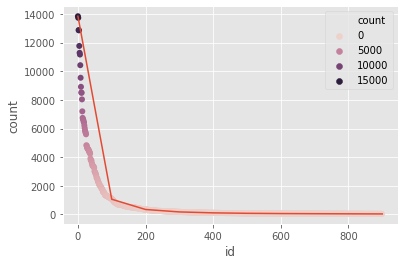

In [ ]:
# Plot summarizing how the count drops
ax = sns.lineplot(x='id', y='count', data=uq_lg_dist[uq_lg_dist.id % 100 == 0][:10])
ax = sns.scatterplot(x='id', y='count', data=uq_lg_dist[:900], linewidth=0, hue="count")

Working with only first 150 interventions

In [ ]:
# Specify top x interventions to consider
n_interventions = 150

In [ ]:
uq_lg_dist.head()

,id,intervention,count
0,0,Antibodies,13839
1,1,Paclitaxel,13731
2,2,Albumin-Bound Paclitaxel,12867
3,3,Bevacizumab,12859
4,4,Immunoglobulins,11766


In [ ]:
print(f"It means we decided on interventions with at least {uq_lg_dist.loc[n_interventions, 'count']} condition entries")

It means we decided on interventions with at least 525 condition entries


In [ ]:
# Inner join uq_lg_dist and uq_lg_data on intervention
temp_uq_lg_data = uq_lg_data.reset_index().merge(uq_lg_dist[uq_lg_dist['id'] < n_interventions], on='intervention').set_index('index') # Resetting and setting index to preserve df indices

In [ ]:
temp_uq_lg_data_labels = to_categorical(temp_uq_lg_data['id'].values)

In [ ]:
temp_uq_lg_data_labels

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

Splitting to make intervention classifier dataset

In [ ]:
intervention_seed = 10

In [ ]:
cond_intv_X_train, cond_intv_X_test, cond_intv_y_train, cond_intv_y_test = train_test_split(temp_uq_lg_data['condition'],
                                                                                            temp_uq_lg_data['id'],
                                                                                            test_size=0.20,
                                                                                            random_state=intervention_seed,
                                                                                            stratify=temp_uq_lg_data['id'])

In [ ]:
#temp_uq_lg_data.index.get_loc(121419)

In [ ]:
# Use split index to get associated one hot matrix
cond_intv_y_train_labels = temp_uq_lg_data_labels[temp_uq_lg_data.index.get_indexer_for(cond_intv_y_train.index)]
cond_intv_y_test_labels = temp_uq_lg_data_labels[temp_uq_lg_data.index.get_indexer_for(cond_intv_y_test.index)]

### K-Fold dataset feeder

In [ ]:
from sklearn.model_selection import StratifiedKFold

In [ ]:
# Specify number of k folds 
k_folds_value = 7 # 2 or greater

In [ ]:
kfold_seed = 15

In [ ]:
# Stratified K-Fold Generator
# This function must receive associated [df, embedding_matrix and one_hot_label_matrix] along with x & y column names

def kfold_train_test_generator(dataset, x, y, k_splits, seed, embedding_matrix, one_hot_label_matrix):
  s_kf = StratifiedKFold(n_splits = k_splits, shuffle = True, random_state = seed)
  
  # Feeds X_train, X_test, y_train, y_test ... 'k_splits' times
  for idx, (train_indices, test_indices) in enumerate(s_kf.split(dataset[x], dataset[y])):
    print(f"Split {idx} row count: Train [{train_indices.shape[0]}] ---- Test [{train_indices.shape[0]}]")

    yield (embedding_matrix[train_indices], embedding_matrix[test_indices],
          one_hot_label_matrix[train_indices], one_hot_label_matrix[test_indices])

### Validation sets (Only used while finetuning)

Preiviously created training sets further split into training and validation sets.
 
[Split config: 90%-10%]

y -> Eligibility

In [ ]:
# Stratified split using same seed to match rows
fine_pres_elg_X_train, fine_pres_elg_X_val, fine_pres_elg_y_train, fine_pres_elg_y_val = train_test_split(pres_elg_X_train, pres_elg_y_train, test_size=0.10, random_state=eligbitliy_seed, stratify=pres_elg_y_train)
fine_cond_elg_X_train, fine_cond_elg_X_val, fine_cond_elg_y_train, fine_cond_elg_y_val = train_test_split(cond_elg_X_train, cond_elg_y_train, test_size=0.10, random_state=eligbitliy_seed, stratify=cond_elg_y_train)


y -> Intervention

In [ ]:
fine_cond_intv_X_train, fine_cond_intv_X_val, fine_cond_intv_y_train, fine_cond_intv_y_val = train_test_split(cond_intv_X_train,
                                                                                            cond_intv_y_train,
                                                                                            test_size=0.10,
                                                                                            random_state=intervention_seed,
                                                                                            stratify=cond_intv_y_train)

### Outputtting all finetuning dfs

In [ ]:
# pd.concat([fine_pres_elg_X_train, fine_pres_elg_y_train], axis = 1).reset_index(drop=True).to_csv('task1_pres_elg_train.csv', index=False)
# pd.concat([fine_pres_elg_X_val, fine_pres_elg_y_val], axis = 1).reset_index(drop=True).to_csv('task1_pres_elg_val.csv', index=False)
# pd.concat([pres_elg_X_test, pres_elg_y_test], axis = 1).reset_index(drop=True).to_csv('task1_pres_elg_test.csv', index=False)
# pd.concat([fine_cond_elg_X_train, fine_cond_elg_y_train], axis = 1).reset_index(drop=True).to_csv('task2_cond_elg_train.csv', index=False)
# pd.concat([fine_cond_elg_X_val, fine_cond_elg_y_val], axis = 1).reset_index(drop=True).to_csv('task2_cond_elg_val.csv', index=False)
# pd.concat([cond_elg_X_test, cond_elg_y_test], axis = 1).reset_index(drop=True).to_csv('task2_cond_elg_test.csv', index=False)
# pd.concat([fine_cond_intv_X_train, fine_cond_intv_y_train], axis = 1).reset_index(drop=True).to_csv('task3_cond_intv_train.csv', index=False)
# pd.concat([fine_cond_intv_X_val, fine_cond_intv_y_val], axis = 1).reset_index(drop=True).to_csv('task3_cond_intv_val.csv', index=False)
# pd.concat([cond_intv_X_test, cond_intv_y_test], axis = 1).reset_index(drop=True).to_csv('task3_cond_intv_test.csv', index=False)

Uploading to Google drive

In [ ]:
task_csv_filenames = ['task1_pres_elg_train.csv', 'task1_pres_elg_val.csv', 'task1_pres_elg_test.csv', 'task2_cond_elg_train.csv', 'task2_cond_elg_val.csv', 'task2_cond_elg_test.csv', 'task3_cond_intv_train.csv', 'task3_cond_intv_val.csv', 'task3_cond_intv_test.csv']

In [ ]:
for csv_filename in task_csv_filenames:
  save_to_drive(from_dir_path=f'{csv_filename}', to_path="/content/drive/My Drive/model_csv_files/bert", folder_prefix="", from_is_file=True)

Saving model on google drive...
Model saved.
Saving model on google drive...
Model saved.
Saving model on google drive...
Model saved.
Saving model on google drive...
Model saved.
Saving model on google drive...
Model saved.
Saving model on google drive...
Model saved.
Saving model on google drive...
Model saved.
Saving model on google drive...
Model saved.
Saving model on google drive...
Model saved.


## Finetuning BERT

### Objective
Finetune BERT for 3 seperate tasks:
- **`Task 1`** Input: Prescription -> Output: Eligibility (Binary)
- **`Task 2`** Input: Condition -> Output: Eligibility (Binary)
- **`Task 3`** Input: Condition ->  Output: Intervention (Multi class)

BERT Finetuning task: Sequence Classification

Using ['BertForSequenceClassification'](https://huggingface.co/transformers/model_doc/bert.html#tfbertforsequenceclassification) interface from [huggingface](https://huggingface.co/)

### Prerequisites 

Detect GPU

In [ ]:
import tensorflow as tf

# Get the GPU device name
device_name = tf.test.gpu_device_name()

if device_name == '/device:GPU:0':
  print(f'Found GPU at {device_name}')
else:
  raise SystemError('GPU device not found')

Found GPU at /device:GPU:0


Import PyTorch and specify GPU as a device to use

In [ ]:
import torch

# Check if GPU is avaiable
if torch.cuda.is_available():
  # Make PyTorch use the GPU
  device = torch.device("cuda")

  print(f'There are {torch.cuda.device_count()} GPU(s) available.')
  print(f'We will use the GPU:', torch.cuda.get_device_name(0))

else:
  print('No GPU available, using the CPU instead')
  device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla K80


Install Apex

In [ ]:
# %%writefile setup.sh

# git clone https://github.com/NVIDIA/apex
# pip install -v --no-cache-dir --global-option="--cpp_ext" --global-option="--cuda_ext" ./apex

In [ ]:
# !sh setup.sh

In [ ]:
# from apex import amp

Install HuggingFace Library

In [ ]:
!pip install transformers

     |████████████████████████████████| 778kB 2.6MB/s 
     |████████████████████████████████| 3.0MB 24.5MB/s 
     |████████████████████████████████| 1.1MB 18.5MB/s 
     |████████████████████████████████| 890kB 39.7MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893260 sha256=87159e9dbfc0c2e3d556dbbbc120fef086be0321467eeb03cc9958db0c4543cd
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


### Dataset info


>Task No. | Mode | Input | Input Shape | Output | Output Shape
>--- | --- | --- | --- | --- | ---
>1 | Training | fine_pres_elg_X_train | (429636,) | fine_pres_elg_y_train | (429636,)
>  | | fine_pres_elg_X_val | (47738,) | fine_pres_elg_y_val | (47738,)
>  | Testing | pres_elg_X_test | (119344,) | pres_elg_y_test | (119344,)
>2 | Training | fine_cond_elg_X_train | (429636,)  | fine_cond_elg_y_train | (429636,)
>  | | fine_cond_elg_X_val | (47738,) | fine_cond_elg_y_val | (47738,)
>  | Testing | cond_elg_X_test | (119344,) | cond_elg_y_test | (119344,)
>3 | Training | fine_cond_intv_X_train | (317174,)  | fine_cond_intv_y_train | (317174,)
>  | | fine_cond_intv_X_val | (35242,) | fine_cond_intv_y_val | (35242,)
>  | Testing | cond_intv_X_test |  (88105,) | cond_intv_y_test | (88105,)

### Pretrained Models Info

>Architecture | Model shortcut name | Details of the model
>--- | --- | --- 
> BERT | bert-base-uncased | 12-layer, 768-hidden, 12-heads, 110M parameters. Trained on lower-cased English text.
>  | bert-large-uncased | 24-layer, 1024-hidden, 16-heads, 340M parameters. Trained on lower-cased English text.

### Tokenization & Input Formatting

Transforming datasets into a format BERT can be trained on

Input format expected for each sequence: `"[CLS] text_sequence [SEP]"`

#### Load BERT Tokenizer

Text is split into tokens, and then these tokens are mapped to their index as per the BERT Tokenizer vocabulory. We try both cased(case preserved) and uncased(no casing/lowercase) version of Tokenizer.

In [ ]:
from transformers import BertTokenizer

In [ ]:
# Download and load BERT tokenizer
def get_bert_tokenizer():
  tokenizer = BertTokenizer.from_pretrained(model_config['model_name'], do_lower_case=True)
  return tokenizer

#### Maximum sequence length identifier

In [ ]:
def get_max_seq_length(X):
  max_len = 0

  # Iterate through each sequece
  for sent in X.values:

    # Tokenizing the text and add '[CLS]' and '[SEP]' tokens to identify length.
    input_ids = tokenizer.encode(sent, add_special_tokens=True)

    # Update the maximum sentence length
    max_len = max(max_len, len(input_ids))

  print(f'Max sequence length: ', max_len)  
  return max_len

#### Input Prep Function 

We encode sentences using utility function developed by HuggingFace. That does more than simply encoding the sequences.

     `tokenizer.encode_plus` will:
       (1) Tokenize the sentence.
       (2) Prepend the `[CLS]` token to the start.
       (3) Append the `[SEP]` token to the end.
       (4) Map tokens to their IDs.
       (5) Pad or truncate the sentence to `max_length`
       (6) Create attention masks for [PAD] tokens. (simply an array of 1s and 0s indicating which tokens are padding and which aren’t)



In [ ]:
# Tokenize all the sentences and map the tokens to their word IDs.
def prepare_input(X, labels, input_max_len, truncation=True, pad_to_max_length=True, return_attention_mask=True, return_tensors='pt', print_complete_status=True):
  # Containers
  input_ids = []
  attention_masks = []
  
  # Iterate through each sequece
  for sent in X.values:
    # encod_plus() returns a dict
    encoded_dict = tokenizer.encode_plus(
        sent,
        add_special_tokens = True,                      # Add '[CLS]' and '[SEP]'
        max_length = input_max_len,
        truncation=truncation,
        pad_to_max_length = pad_to_max_length,          # Pad & truncate all sentences.
        return_attention_mask = return_attention_mask,  # Construct attn. masks.
        return_tensors = return_tensors,                # Return pytorch tensors.
    )

    # Add the encoded sentence to the list.
    input_ids.append(encoded_dict['input_ids'])

    # Also its attention mask
    attention_masks.append(encoded_dict['attention_mask'])
  
  # Convert list into tensor
  input_ids = torch.cat(input_ids, dim=0)
  attention_masks = torch.cat(attention_masks, dim=0)
  labels = torch.tensor(labels.values)
  
  if print_complete_status:
    print(f'Input Ready!')
  return (input_ids, attention_masks, labels)

### Dataset Wrapper and Iterator

Wrap data into a TensorDataset and create an iterator for it using DataLoader (This helps save on memory during training because, unlike a for loop, with an iterator the entire dataset does not need to be loaded into memory.)

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

In [ ]:
def data_wrapper_iterator(input_ids, attention_masks, labels, sampler_type):
  """
  sampler_types: ['sequential', 'random}

  sequential: used when order doesnt matter
  random: used when training samples
  """

  # Combine the training input into a TensorDataset
  dataset = TensorDataset(input_ids, attention_masks, labels)

  dataloader = None

  # Create iterator(DataLoader) for dataset
  if (sampler_type == "sequential"):
    dataloader = DataLoader(
        dataset,
        sampler = SequentialSampler(dataset),
        batch_size = model_config['batch_size']
    )
  else:
    dataloader = DataLoader(
        dataset,
        sampler = RandomSampler(dataset),
        batch_size = model_config['batch_size']
    )
  return (dataset, dataloader)


### Classification Model

The huggingface pytorch implementation includes a set of interfaces designed for a variety of NLP tasks. Though these interfaces are all built on top of a trained BERT model, each has different top layers and output types designed to accomodate their specific NLP task.
We'll be using 

`BertForSequenceClassification`. This is the normal BERT model with an added single linear layer on top for classification that we will use as a sentence classifier. As we feed input data, the entire pre-trained BERT model and the additional untrained classification layer is trained on our specific task.

In [ ]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

In [ ]:
def define_classification_model(num_labels):
  # Load BertForSequenceClassification, the pretrained BERT model with a single 
  # linear classification layer on top.
  model = BertForSequenceClassification.from_pretrained(
      model_config['model_name'],
      num_labels = num_labels,
      output_attentions = False, # Whether the model returns attentions weights.
      output_hidden_states = False, # Whether the model returns all hidden states
  )

  # Make the model run on GPU
  model.cuda()
  return model

In [ ]:
# Print Params
def print_model_params_overview(model):
  params = list(model.named_parameters())
  print(f'The BERT model has {len(params):} different named parameters.\n')

  print('==== Embedding Layer ====\n')
  for p in params[0:5]:
      print(f"{p[0]:<55} {str(tuple(p[1].size())):>12}")

  print('\n==== First Transformer ====\n')
  for p in params[5:21]:
      print(f"{p[0]:<55} {str(tuple(p[1].size())):>12}")

  print('\n==== Output Layer ====\n')
  for p in params[-4:]:
      print(f"{p[0]:<55} {str(tuple(p[1].size())):>12}")

### Optimizer & Learning rate scheduler

In [ ]:
# Retrieve and modify pretrained model's training hyper parameters
# Initialize Adam Optimizer
def get_adam_optimizer(model):
  optimizer = AdamW(
      model.parameters(),
      lr = model_config['learning_rate'], # default is 5e-5,
      eps = model_config['eps']           # default is 1e-8
  )
  return optimizer

In [ ]:
from transformers import get_linear_schedule_with_warmup

In [ ]:
def get_linear_learning_rate_scheduler(model, optimizer, dataloader, grad_accumulation_steps=1):
  # Determine total number of training steps
  # [number of batches in an epoch] x [number of epochs]
  total_steps = (len(dataloader) * grad_accumulation_steps) * model_config['n_epochs']

  # Learning rate scheduler
  scheduler = get_linear_schedule_with_warmup(
      optimizer,
      num_warmup_steps = 0,
      num_training_steps = total_steps
  )

  return scheduler


### Helper Functions
- Measure Accuracy
- Measure Elapsed Time

In [ ]:
def get_accuracy(preds, labels):
  '''
  Compute mean accuracy 
  '''
  pred = np.argmax(preds, axis=1).flatten()
  labels = labels.flatten()

  return np.sum(pred == labels) / len(labels) # mean

In [ ]:
def format_time(elapsed):
  '''
  Takes a time in seconds and returns a string hh:mm:ss
  '''
  # Round to the nearest second.
  elapsed_rounded = int(round((elapsed)))
  
  # Format as hh:mm:ss
  return str(datetime.timedelta(seconds=elapsed_rounded))

### Trainer & Validator

In [ ]:
def train(model, train_dataloader, tokenizer, optimizer, scheduler, seed_value,
          validation_dataloader=None, use_validation=True, grad_accumulation_steps=1, output_dir_name='model_save', save_on_gdrive=True):
  # If validation is true check if validation_dataloader is supplied, raise error if not
  if use_validation and (validation_dataloader == None):
    raise SystemError('validation_dataloader needed to perform validation!')

  # Seed RNGs
  random.seed(seed_value)
  np.random.seed(seed_value)
  torch.manual_seed(seed_value)
  torch.cuda.manual_seed_all(seed_value)

  # Container to store loss and accuracy for each training and validation phase
  # Along with batch intervals and epochs.
  stats = []

  # Training start time
  init_time = time.time()

  for epoch_i in range(0, model_config['n_epochs']):
    # Cycle of our classifier epoch (Train->Update)->Validate

    print(f"\n{'=='*5} Epoch {epoch_i + 1} / {model_config['n_epochs']} {'=='*5}")
    print("Training...")
    
    # Epoch start time
    t0 = time.time()

    # Loss is accumulated and averaged across batches for each epoch
    # We clear the loss for each new epoch
    total_train_loss = 0

    # Enable training mode
    model.train()

    # Clear previously computed gradients for new epoch
    model.zero_grad()

    # total_mini_batch_loss, used for accumulating loss over mini steps
    total_mini_batch_loss = 0

    # Record steps completed, used for computed average training loss
    steps_completed = 0

    # Iterate over all the batches in train_dataloader
    for step, batch in enumerate(train_dataloader):

      # Print progress every 3% batches completed
      if step % 300 == 0 and not step == 0:
        elapsed = format_time(time.time() - t0)
        print(f'  Batch {step:>5}  of  {len(train_dataloader):>5}.    Elapsed: {elapsed:}.')

      # Unpack training batch from train_dataloader
      # Batch contains 3 PyTorch tensors (input_ids, attention_masks, labels)
      # Place each tensor on GPU using to
      b_input_ids = batch[0].to(device)
      b_attention_mask = batch[1].to(device)
      b_labels = batch[2].to(device)

      # Perform forward pass
      loss, logits = model(b_input_ids,
                           token_type_ids=None,
                           attention_mask=b_attention_mask,
                           labels=b_labels)
      
      # # Accumulate the training loss across all the batches
      # total_train_loss += loss.item()

      # Accumulate mini_batch_loss
      total_mini_batch_loss += loss.item()

      # # Clear previously computed gradients # MOD: Don't Clear gradients
      # model.zero_grad()

      # # Perform backward pass using loss to compute the gradient vector 
      # # Simply let the gradients accumulate according to grad_accumulation_steps value
      # loss.backward()
      # Use mixed precision backprop
      with amp.scale_loss(loss, optimizer) as scaled_loss:                      
        scaled_loss.backward()

      # # Fix for Exploding gradients: Normalize them between 1 and 0
      # torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

      # Perform Mini-Batch gradient accumulation
      if (step+1) % grad_accumulation_steps == 0:

        # # Fix for Exploding gradients: Normalize them between 1 and 0
        # torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Accumulate the training loss across all the batches
        total_train_loss += (total_mini_batch_loss / grad_accumulation_steps)

        # Update parameters using accumulated gradients and Adaptive learning rate
        optimizer.step()

        # Update the learning rate
        scheduler.step()

        # Clear accumulated gradients
        model.zero_grad()

        # Reset total_mini_batch_loss
        total_mini_batch_loss = 0

        # Increment steps_completed by 1, because we updated our params
        steps_completed += 1

    # Average the accumulated loss over all the steps
    avg_train_loss = total_train_loss / steps_completed

    # Compute time taken for train in this epoch
    training_time = format_time(time.time() - t0)

    print(f"\n  Training loss: {avg_train_loss:.2f}")
    print(f"  Training took: {training_time:}\n")

    if use_validation:
      print("Running Validation...")

      t0 = time.time()

      # Enable evaluation mode
      model.eval()

      # Performance variables
      total_eval_accuracy = 0
      total_eval_loss = 0
      nb_eval_steps = 0

      for batch in validation_dataloader:
        # Unpack batch to GPU
        b_input_ids = batch[0].to(device)
        b_attention_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Since we dont do backprop while validation we dont need to build compute graph
        with torch.no_grad():

          # Perform forward pass
          loss, logits = model(b_input_ids,
                              token_type_ids=None,
                              attention_mask=b_attention_mask,
                              labels=b_labels)
          
        # Accumulate the validation loss across batches
        total_eval_loss += loss.item()

        # # Move logits and labels to CPU # Bad Practice
        # logits = logits.detach().cpu().numpy()
        # label_ids = b_labels.to('cpu').numpy()

        logits = logits.numpy()
        label_ids = b_labels.numpy()

        # Calculate accuracy for this batch and accumulate
        total_eval_accuracy += get_accuracy(logits, label_ids)

      # Print avg accuracy for this validation 
      avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
      print(f"  Accuracy: {avg_val_accuracy:.2f}")

      # Compute avg loss over all the batches
      avg_val_loss = total_eval_loss / len(validation_dataloader)

      # Compute time taken for Validation in this epoch
      validation_time = format_time(time.time() - t0)

      print(f"  Validation Loss: {avg_val_loss:.2f}")
      print(f"  Validation took: {validation_time:}")

    # Store all the stats for this epoch
    stats_dict = {
      'epoch': (epoch_i + 1),
      'Training Loss': avg_train_loss,
      'Training Time': training_time,
    }

    if use_validation:
      stats_dict['Valid. Loss'] = avg_val_loss
      stats_dict['Valid. Accur.'] = avg_val_accuracy
      stats_dict['Validation Time'] = validation_time

    stats.append(stats_dict)

  print("\nTraining complete!")
  print(f"Total training took {format_time(time.time()-total_t0):} (h:mm:ss)")

  # Save the model
  save_model(model=model, tokenizer=tokenizer, output_dir_name=output_dir_name, on_gdrive=save_on_gdrive)

  return stats

Summarize Finetuning Training Performance

In [ ]:
def summarize_training_stats(stats):
  stats_df = pd.DataFrame(stats).set_index('epoch')
  stats_df.style.format('{:.2f}')

  sns.set(style='darkgrid')
  sns.set(font_scale=1.5)
  plt.rcParams["figure.figsize"] = (12,6)

  plt.plot(stats_df['Training Loss'], 'b-o', label="Training")
  if 'Valid. Loss' in stats:
    plt.plot(stats_df['Valid. Loss'], 'g-o', label="Validation")
  
  plt.title("Loss Plot")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend()
  plt.xticks([1, 2, 3, 4])
  plt.show()

  return stats_df

### Prediction function

In [ ]:
def predict(model, dataloader):
  print("Running Validation...")

  # Enable evaluation mode
  model.eval()

  # Output container variables
  predictions = []
  true_labels = []

  for batch in dataloader:
    # Unpack batch to GPU
    b_input_ids = batch[0].to(device)
    b_attention_mask = batch[1].to(device)
    b_labels = batch[2].to(device)

    # Since we dont do backprop while predicting, we dont need to build compute graph, Speed UP!
    with torch.no_grad():

      # Perform forward pass
      outputs = model(b_input_ids,
                     token_type_ids=None,
                     attention_mask=b_attention_mask)
      
    logits = output[0]

    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    predictions.append(logits)
    true_labels.append(label_ids)

  print('Predictions done!')

  return (predictions, true_labels)


### Model Saver

In [ ]:
def save_model(model, tokenizer, output_dir_name='model_save', on_gdrive=False):
  output_dir = f'./{output_dir_name}/'
  # Create output directory if doesn't exist
  if not os.path.exists(output_dir):
    os.makedirs(output_dir)
  print(f"Saving model to /{output_dir} ....")
  # Save a trained model, configuration and tokenizer using `save_pretrained()`.
  # They can then be reloaded using `from_pretrained()`
  model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
  model_to_save.save_pretrained(output_dir)
  tokenizer.save_pretrained(output_dir)
  print("Model saved on colab instance.")
  if on_gdrive:
    save_to_drive(from_dir_path=output_dir_name)

In [ ]:
def save_to_drive(from_dir_path='model_save', to_path="/content/drive/My Drive/trained_model_files", folder_prefix="bert", from_is_file=False):
  print(f'Saving model on google drive...')
  from_dir = f"{from_dir_path}"
  to_dir = f"{to_path}/{folder_prefix}_{from_dir}"
  try:
    if from_is_file:
      to_dir = f"{to_path}/"
      if not os.path.exists(to_dir):
        os.makedirs(to_dir)
      shutil.copy2(from_dir, to_dir)
    else:
      if not os.path.exists(to_dir):
        os.makedirs(to_dir)
      copy_tree(from_dir, to_dir)
    print(f'Model saved.')
  except:
    print(f"Copy to Google drive failed: {sys.exc_info()[-2:]}")

### Run Finetune

#### Dataset info


>Task No. | Mode | Input | Input Shape | Output | Output Shape
>--- | --- | --- | --- | --- | ---
>1 | Training | fine_pres_elg_X_train | (429636,) | fine_pres_elg_y_train | (429636,)
>  | | fine_pres_elg_X_val | (47738,) | fine_pres_elg_y_val | (47738,)
>  | Testing | pres_elg_X_test | (119344,) | pres_elg_y_test | (119344,)
>2 | Training | fine_cond_elg_X_train | (429636,)  | fine_cond_elg_y_train | (429636,)
>  | | fine_cond_elg_X_val | (47738,) | fine_cond_elg_y_val | (47738,)
>  | Testing | cond_elg_X_test | (119344,) | cond_elg_y_test | (119344,)
>3 | Training | fine_cond_intv_X_train | (317174,)  | fine_cond_intv_y_train | (317174,)
>  | | fine_cond_intv_X_val | (35242,) | fine_cond_intv_y_val | (35242,)
>  | Testing | cond_intv_X_test |  (88105,) | cond_intv_y_test | (88105,)

Some task independent declarations 

In [ ]:
def create_input_tensor_task_dir(task_num):
  if not os.path.exists("input_tensors"):
    os.makedirs(f"input_tensors")
  os.makedirs(f"input_tensors/task_{task_num}")  

In [ ]:
def remove_input_tensors(del_input_task_num=None):
  if del_input_task_num != None:
    shutil.rmtree(f"input_tensors/task_{del_input_task_num}")
    if (len(os.listdir("input_tensors/")) == 0):
      shutil.rmtree("input_tensors")
  else:
    shutil.rmtree("input_tensors")

In [ ]:
def del_directory_tree(folder_name):
  shutil.rmtree(f"{folder_name}")
  print(f"{folder_name} tree deleted.")

In [ ]:
# create_input_tensor_task_dir(task_num=1)

In [ ]:
# remove_input_tensors(1)

#### Model Config

In [ ]:
model_config = {
    "model_name": "bert-base-uncased",
    "batch_size": 16,
    "n_epochs": 1,
    "learning_rate": 5e-5,
    "eps": 1e-8,
    'grad_accumulation_steps': 1
}

In [ ]:
tokenizer = get_bert_tokenizer()

**Max token lengths discovered in below section**

Task 1:(pres -> elg) max_len = `410`
  - fine_pres_elg_X_train -> 408
  - fine_pres_elg_X_val -> 267
  - pres_elg_X_test -> 277

Task 2:(cond -> elg) max_len = `392`
  - fine_cond_elg_X_train -> 390
  - fine_cond_elg_X_val -> 249
  - cond_elg_X_test -> 268

Task 3:(cond -> intv) max_len = `271`
  - fine_cond_intv_X_train -> 269
  - fine_cond_intv_X_val -> 245
  - cond_intv_X_test -> 263


In [ ]:
task1_max_len = 410
task2_max_len = 392
task3_max_len = 271

#### Discover max token length for each task

In [ ]:
# pTrain_max_len = get_max_seq_length(fine_pres_elg_X_train)

In [ ]:
# pTest_max_len = get_max_seq_length(fine_pres_elg_X_val)

In [ ]:
# pEval_max_len = get_max_seq_length(pres_elg_X_test)

In [ ]:
# cTrain_max_len = get_max_seq_length(fine_cond_elg_X_train)

In [ ]:
# cTest_max_len = get_max_seq_length(fine_cond_elg_X_val)

In [ ]:
# cEval_max_len = get_max_seq_length(cond_elg_X_test)

In [ ]:
# cintTrain_max_len = get_max_seq_length(fine_cond_intv_X_train)

In [ ]:
# cintTest_max_len = get_max_seq_length(fine_cond_intv_X_val)

In [ ]:
# cintEval_max_len = get_max_seq_length(cond_intv_X_test)

#### Token distribution analysis

In [ ]:
def get_token_dist_dict(X, y):
  token_dist_dict = {
      'index': [],
      'token_count': []
  }
  for idx in range(X.shape[0]):
    in_ids, _, _ = prepare_input(X=X[idx:idx+1],
                                labels=y[idx:idx+1],
                                input_max_len=None,
                                truncation=False,
                                pad_to_max_length=False,
                                return_attention_mask=None,
                                return_tensors='pt',
                                print_complete_status=False)
    token_dist_dict['index'].append(idx)
    token_dist_dict['token_count'].append(len(in_ids[0]))

  print("Done")
  return token_dist_dict

In [ ]:
# pres_token_dist_dict = get_token_dist_dict(uq_lg_data['prescription'], uq_lg_data['label'])

Done


In [ ]:
# pres_token_dist_df = pd.DataFrame(pres_token_dist_dict)

In [ ]:
# pres_token_dist_df.plot(x='index', y='token_count')

In [ ]:
# pres_token_dist_df.to_csv('data/pres_token_dist_df.csv', index=False)

In [ ]:
# cond_token_dist_dict = get_token_dist_dict(uq_lg_data['condition'], uq_lg_data['label'])

Done


In [ ]:
# cond_token_dist_df = pd.DataFrame(cond_token_dist_dict)

In [ ]:
# cond_token_dist_df.to_csv('data/cond_token_dist_df.csv', index=False)

#### `Task 1`:  Input: Prescription -> Output: Eligibility

prepare_input() takes considerable amount of time, better save the generated tensors in a dictionary

In [ ]:
# Uncomment when input needs to reparsed or haven't parsed
# remove_input_tensors()

In [ ]:
if not os.path.exists("input_tensors/task_1"):
  # Tokenize training and validation data 
  t1_train_input_ids, t1_train_attention_masks, t1_train_labels = prepare_input(X=fine_pres_elg_X_train, labels=fine_pres_elg_y_train, input_max_len=task1_max_len)
  t1_val_input_ids, t1_val_attention_masks, t1_val_labels = prepare_input(X=fine_pres_elg_X_val, labels=fine_pres_elg_y_val, input_max_len=task1_max_len)
  # Create Task directory
  create_input_tensor_task_dir(task_num=1)
  # Create dict map for tensors
  t1_input_tensors = {
      't1_train_input_ids': t1_train_input_ids,
      't1_train_attention_masks': t1_train_attention_masks,
      't1_train_labels': t1_train_labels,
      't1_val_input_ids': t1_val_input_ids,
      't1_val_attention_masks': t1_val_attention_masks,
      't1_val_labels': t1_val_labels
  }
  torch.save(t1_input_tensors, f'input_tensors/task_1/t1_input_tensors')    
else:
  # input_tensors for task_1 already exist, so we just load them back
  t1_input_tensors = torch.load(f'input_tensors/task_1/t1_input_tensors')
  t1_train_input_ids = t1_input_tensors['t1_train_input_ids']
  t1_train_attention_masks = t1_input_tensors['t1_train_attention_masks']
  t1_train_labels = t1_input_tensors['t1_train_labels']
  t1_val_input_ids = t1_input_tensors['t1_val_input_ids']
  t1_val_attention_masks = t1_input_tensors['t1_val_attention_masks']
  t1_val_labels = t1_input_tensors['t1_val_labels']

In [ ]:
# Create Training and Validation Loader
_, t1_train_loader = data_wrapper_iterator(input_ids=t1_train_input_ids, attention_masks=t1_train_attention_masks, labels=t1_train_labels, sampler_type="random")
_, t1_val_loader = data_wrapper_iterator(input_ids=t1_val_input_ids, attention_masks=t1_val_attention_masks, labels=t1_val_labels, sampler_type="sequential")

In [ ]:
t1_num_labels = 2

In [ ]:
# Get object object
t1_model = define_classification_model(num_labels=t1_num_labels)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [ ]:
# Overview of Model Params
print_model_params_overview(model=t1_model)

The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (30522, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              (

In [ ]:
# Intialize Adam(with weight decay fix) optimizer
t1_optimizer = get_adam_optimizer(model=t1_model)

In [ ]:
t1_model, t1_optimizer = amp.initialize(t1_model, t1_optimizer, opt_level='O2')

Selected optimization level O2:  FP16 training with FP32 batchnorm and FP32 master weights.

Defaults for this optimization level are:
enabled                : True
opt_level              : O2
cast_model_type        : torch.float16
patch_torch_functions  : False
keep_batchnorm_fp32    : True
master_weights         : True
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O2
cast_model_type        : torch.float16
patch_torch_functions  : False
keep_batchnorm_fp32    : True
master_weights         : True
loss_scale             : dynamic


In [ ]:
# Intialize Learning rate scheduler for adam
t1_learning_rate_scheduler = get_linear_learning_rate_scheduler(model=t1_model, 
                                                                optimizer=t1_optimizer, 
                                                                dataloader=t1_train_loader,
                                                                grad_accumulation_steps=model_config['grad_accumulation_steps'])

Finetune t1_model for task 1

In [ ]:
t1_seed_value = 46

In [ ]:
# Function call reference 
# train(model, train_dataloader, tokenizer, optimizer, scheduler, seed_value, validation_dataloader=None, use_validation=True, grad_accumulation_steps=1, output_dir_name='model_save', save_on_gdrive=True)

In [ ]:
t1_finetune_stats = train(model=t1_model,
                       train_dataloader=t1_train_loader,
                       tokenizer=tokenizer,
                       optimizer=t1_optimizer,
                       scheduler=t1_learning_rate_scheduler,
                       seed_value=t1_seed_value,
                       validation_dataloader=t1_val_loader,
                       use_validation=True,
                       grad_accumulation_steps=model_config['grad_accumulation_steps'])


========== Epoch 1 / 1 ==========
Training...
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 32768.0


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:123: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


  Batch   300  of  26853.    Elapsed: 0:02:15.
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0
  Batch   600  of  26853.    Elapsed: 0:04:26.


KeyboardInterrupt: ignored

In [ ]:
# tokenizer.encode_plus()

In [ ]:
# fine_pres_elg_X_train.apply(lambda x: len(x.split()))>400

In [ ]:
# fine_pres_elg_X_train[fine_pres_elg_X_train.apply(lambda x: len(x.split())>205)]

In [ ]:
# some_dict = tokenizer.encode_plus(
#         fine_pres_elg_X_train[9215],
#         add_special_tokens = True,    # Add '[CLS]' and '[SEP]'
#         max_length = 208,
#         truncation=True,
#         pad_to_max_length = True,     # Pad & truncate all sentences.
#         return_attention_mask = True, # Construct attn. masks.
#         return_tensors = 'pt',        # Return pytorch tensors.
#     )

In [ ]:
# some_dict

In [ ]:
# tokenizer.encode(fine_pres_elg_X_train[9215], add_special_tokens=True)

In [ ]:
# fine_pres_elg_X_train[9215]

## Embeddings

Generate BERT sentence embeddings:
- Prescription
- Condition

Embeddings used in:
- pres_elg_X_train
- pres_elg_X_test
- cond_elg_X_train
- cond_elg_X_test
- cond_intv_X_train
- cond_intv_X_test

In [ ]:
i = 10
while (i > 0):
  if (i == 5):
      i -= 1
      continue
  print(i)
  i -= 1

10
9
8
7
6
4
3
2
1


In [ ]:
def kinetic_energy(m:'in KG', v:'in M/S')-> List['Example']:
  trex = 'Example'(1/2*m*v**2)
  return [trex for i in range(3)]

In [ ]:
 kinetic_energy(2, 10)

TypeError: ignored

In [ ]:
kinetic_energy.__annotations__

{'m': 'in KG', 'return': typing.List[_ForwardRef('Example')], 'v': 'in M/S'}